Helper libraries: Optax and Haiku
=================================

While you can build and train neural networks in pure JAX, it may be more convenient to use some helper libraries.

We import the same libraries and data as in the earlier example, but additionally import haiku and optax.

In [10]:
!pip install dm-haiku optax

In [5]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import haiku as hk     # Library to build models / neural networks
import optax           # Library for optimization

data = pd.read_csv("https://raw.githubusercontent.com/MScherbela/jax_tutorial/master/data/qm7.csv")
n_train = 6000
X = data.values[:, :-1].reshape([-1, 23, 23])
Y = data.values[:, -1]
ind = np.random.permutation(len(X))
X_train, X_test = np.split(X[ind], [n_train])
y_train, y_test = np.split(Y[ind], [n_train])
y_offset, y_scale = np.mean(y_train), np.std(y_train)

n_epochs = 100
batch_size = 200
learning_rate = 1e-3
n_hidden_neurons = [50, 50, 20]

Defining the model: Haiku
-------------------------

Instead of writing the model from scratch, we now use haiku to define the model.
Advantages:
- **Better readability** for larger models
- **Many pre-built modules**, e.g. multi-layer-perceptrons, convolutional networks, ...
- **Automatic initialization** of parameters
- **Automatic handling of parameters and state** within the model


How to build a model in Haiku?
1. Define as a subclass of hk.Module
2. Store any configs in the `__init__` method and implement the forward pass in the `__call__`method
3. Convert the model to pure JAX functions using `hk.transform`. This creates 2 pure functions: `model.init`to initialize the parameters and `model.apply` to run the model

In [6]:
class Model(hk.Module):
    def __init__(self, n_hidden_neurons, y_offset, y_scale, name=None):
        super().__init__(name=name)
        self.n_hidden_neurons = n_hidden_neurons
        self.y_offset = y_offset
        self.y_scale = y_scale

    def __call__(self, x, is_training):
        x = jnp.linalg.eigvalsh(x)
        x = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.95)(x, is_training)
        y = hk.nets.MLP(self.n_hidden_neurons + [1])(x)
        return y[:,0] * self.y_scale + self.y_offset

model = hk.transform_with_state(lambda x,is_training: Model(n_hidden_neurons, y_offset, y_scale)(x, is_training))
model = hk.without_apply_rng(model)

# We now get 2 functions: model.init and model.apply
rng_key = jax.random.PRNGKey(seed=1234)
params, func_state = model.init(rng_key, X_train, True)


Defining the optimizer: Optax
-----------------------------

Implementing stochastic gradient descent was easy, but more advanced optimizers can trickier.
**Optax** is a library that allows us to easily build and combine optimizers that all work on this principle:

1. Build the optimizer
2. Initialize its internal state (e.g. its momentum)
3. Make gradient steps by optimizer.update:
       a. Takes in: *gradients*, the *current optimizer state* and the *current set of parameters*
       b. Returns: *parameter updates* and *new optimizer state*


In [7]:
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

def loss_func(params, func_state, x, y_target):
    y_pred, func_state = model.apply(params, func_state, x, True)
    residual = (y_pred - y_target) / y_scale
    return jnp.mean(residual**2), func_state

@jax.jit
def training_step(params, func_state, opt_state, batch):
    x, y_target = batch
    (loss, func_state), grad = jax.value_and_grad(loss_func, has_aux=True)(params, func_state, x, y_target)
    delta_params, opt_state = optimizer.update(grad, opt_state, params)
    params = optax.apply_updates(params, delta_params)
    return loss, params, func_state, opt_state

def make_batches(x, y, batch_size):
    indices = np.random.permutation(len(x))
    x = x[indices]
    y = y[indices]
    for k in range(0, len(x), batch_size):
        yield x[k:k+batch_size], y[k:k+batch_size]


We run the same training loop as in the earlier example.

In [8]:
@jax.jit
def evaluate_model(params, func_state, X, y_target):
    y_pred, _ = model.apply(params, func_state, X, False)
    return y_pred, jnp.mean(jnp.abs(y_pred - y_target))

mae_test = np.zeros(n_epochs)
mae_train = np.zeros(n_epochs)
loss = np.zeros(n_epochs * n_train // batch_size)
ind_step = 0
params_averaged = params
for ind_epoch in range(n_epochs):
    for batch in make_batches(X_train, y_train, batch_size):
        loss[ind_step], params, func_state, opt_state = training_step(params, func_state, opt_state, batch)
        params_averaged = optax.incremental_update(params, params_averaged, 0.01)
        ind_step += 1
    y_pred_train, mae_train[ind_epoch] = evaluate_model(params_averaged, func_state, X_train, y_train)
    y_pred_test, mae_test[ind_epoch] = evaluate_model(params_averaged, func_state, X_test, y_test)
    if (ind_epoch % 5) == 0:
        print(f"epoch={ind_epoch:<3d}: mae_train={mae_train[ind_epoch]:.1f} kcal/mol, mae_test={mae_test[ind_epoch]:.1f} kcal/mol")

epoch=0  : mae_train=139.4 kcal/mol, mae_test=139.3 kcal/mol
epoch=5  : mae_train=41.8 kcal/mol, mae_test=42.0 kcal/mol
epoch=10 : mae_train=21.7 kcal/mol, mae_test=22.0 kcal/mol
epoch=15 : mae_train=17.8 kcal/mol, mae_test=18.1 kcal/mol
epoch=20 : mae_train=16.4 kcal/mol, mae_test=16.7 kcal/mol
epoch=25 : mae_train=15.9 kcal/mol, mae_test=16.4 kcal/mol
epoch=30 : mae_train=15.3 kcal/mol, mae_test=15.9 kcal/mol
epoch=35 : mae_train=14.8 kcal/mol, mae_test=15.6 kcal/mol
epoch=40 : mae_train=14.4 kcal/mol, mae_test=15.2 kcal/mol
epoch=45 : mae_train=14.1 kcal/mol, mae_test=15.0 kcal/mol
epoch=50 : mae_train=13.9 kcal/mol, mae_test=14.9 kcal/mol
epoch=55 : mae_train=13.7 kcal/mol, mae_test=14.7 kcal/mol
epoch=60 : mae_train=13.4 kcal/mol, mae_test=14.5 kcal/mol
epoch=65 : mae_train=13.2 kcal/mol, mae_test=14.2 kcal/mol
epoch=70 : mae_train=12.9 kcal/mol, mae_test=13.9 kcal/mol
epoch=75 : mae_train=12.9 kcal/mol, mae_test=14.0 kcal/mol
epoch=80 : mae_train=12.8 kcal/mol, mae_test=14.0 kcal

By using a better optimizer (Adam instead of SGD) we achieve slightly higher accuracies.
Our very naive model, limits accuracy compared to state-of-the-art results (e.g. 3.5 kcal/mol in 2012)

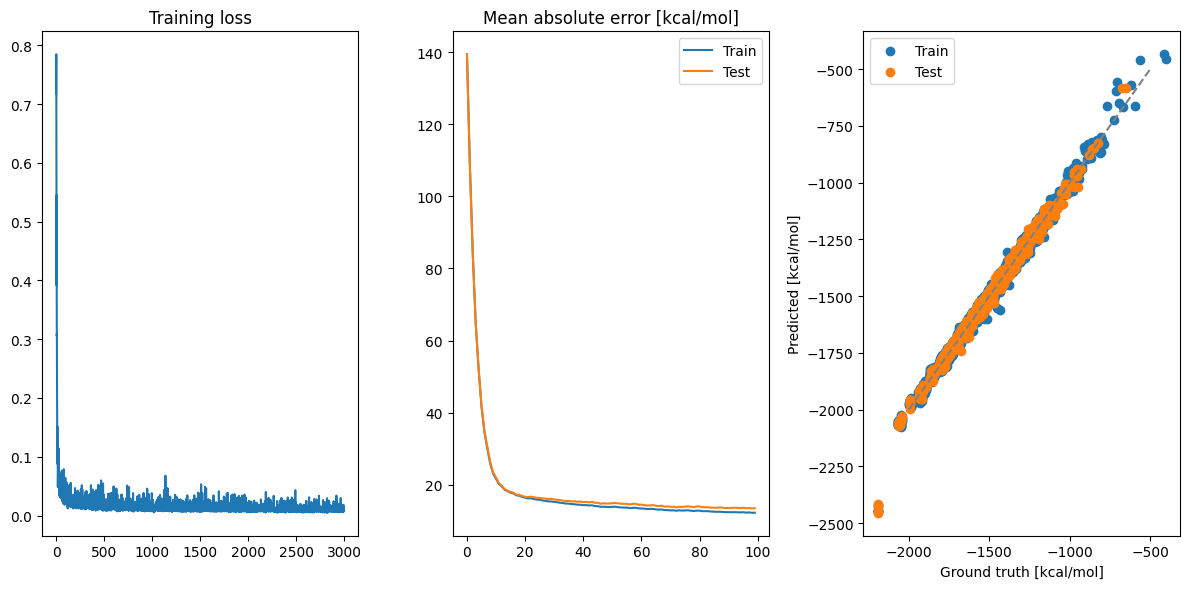

In [9]:
plt.close("all")
fig, axes = plt.subplots(1,3, dpi=100, figsize=(12,6))
axes[0].plot(loss)
axes[0].set_title("Training loss")

axes[1].plot(mae_train, label="Train")
axes[1].plot(mae_test, label="Test")
axes[1].set_title("Mean absolute error [kcal/mol]")
axes[1].legend()

axes[2].scatter(y_train, y_pred_train, label="Train")
axes[2].scatter(y_test, y_pred_test, label="Test")
axes[2].legend()
axes[2].set_xlabel("Ground truth [kcal/mol]")
axes[2].set_ylabel("Predicted [kcal/mol]")
axes[2].plot([-2000, -500], [-2000, -500], color='gray', ls='--')
fig.tight_layout()

